# Converting efficientdet from Tensorflow to ONNX

Google recently [published the new object detection model efficientdet](
https://github.com/google/automl/tree/master/efficientdet) that show state of the art performance and accuracy. 
The models can be found [here](https://github.com/google/automl/tree/master/efficientdet).

This tutorial shows how the efficientdet models to ONNX using tf2onnx.

### Setup a few environment variables

In [ ]:
%matplotlib inline

import os
import time

%cd /tmp
# %cd /mnt/sdb/home/tf/tensorflow/
HOME = os.getcwd()
MODEL = "efficientdet-d2"
os.environ['PYTHONPATH'] = os.path.join(HOME, "tpu")
os.environ['MODEL'] = MODEL
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [ ]:
# download the code. At the time of this writing the last
# commit is 57621e8f3eaddd2c0b421c65c0bbd323ebcf8f2d.
%cd {HOME}
!git clone https://github.com/google/automl

In [ ]:
%cd {HOME}/automl/efficientdet

### Download the model

In [ ]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
!tar -C /tmp -zxf {MODEL}.tar.gz

In [19]:
import tensorflow as tf
import inference
from inference import *
import PIL
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
import matplotlib.pyplot as plt

ONNX does not have operators to read images from the filesystem so we need to change the model inputs of the model a litte to pass the image with a placeholder.

In [ ]:
class Driver(ServingDriver):
    def __init__(self, model_name, ckpt_path,
                 batch_size=1, num_classes=None, label_id_mapping=None):
        super(Driver, self).__init__(model_name, ckpt_path, batch_size, num_classes, label_id_mapping)

    def build(self, params_override=None):
        """Build model and restore checkpoints."""
        params = copy.deepcopy(self.params)
        if params_override:
            params.update(params_override)
        if not self.sess:
            self.sess = self._build_session()
            
        with self.sess.graph.as_default():
            raw_images = tf.placeholder(tf.uint8, name='image_arrays', shape=[None, None, None, 3])
            images, scales = batch_image_preprocess(raw_images, params['image_size'], self.batch_size)
            if params['data_format'] == 'channels_first':
                images = tf.transpose(images, [0, 3, 1, 2])
            class_outputs, box_outputs = build_model(self.model_name, images, **params)
            params.update(
                dict(batch_size=self.batch_size, disable_pyfun=self.disable_pyfun))
            detections = det_post_process(params, class_outputs, box_outputs, scales,
                                          self.min_score_thresh,
                                          self.max_boxes_to_draw)
            restore_ckpt(
                self.sess,
                self.ckpt_path,
                ema_decay=self.params['moving_average_decay'],
                export_ckpt=None)

        self.signitures = {
            'image_arrays': raw_images,
            'prediction': detections,
        }
        return self.signitures


tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
output = os.path.join('.', MODEL)
if tf.io.gfile.exists(output):
    tf.io.gfile.rmtree(output)

driver = Driver(MODEL, os.path.join('/tmp', MODEL), batch_size=1)
driver.build()
driver.export(output)

### Use tf2onnx to convert the model to ONNX

In [ ]:
!pip install git+https://github.com/onnx/tensorflow-onnx
!pip install onnxruntime

In [22]:
!python -m tf2onnx.convert --input {MODEL}/{MODEL}_frozen.pb --output {MODEL}.onnx \
    --inputs image_arrays:0 --outputs detections:0 --opset 11

2020-05-27 21:21:12,840 - WARNING - From /home/ipython/.local/lib/python3.7/site-packages/tf2onnx/tf_loader.py:122: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
2020-05-27 21:21:12,840 - WARNING - From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/graph_util_impl.py:359: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2020-05-27 21:21:12,996 - INFO - Froze 0 variables.
2020-05-27 21:21:13,130 - INFO - Converted 0 variables to const ops.
2020-05-27 21:21:15,052 - INFO - Using tensorflow=2.2.0, onnx=1.7.0, tf2onnx=1.6.0/695e15
2020-05-27 21:21:15,052 - INFO - Using opset <onnx, 11>
2020-05-27 21:21:29,341 - INFO - Optimizing ONNX model
20

### The result format
Now that we have the ONNX model we can write a quick demo using tensorflow and onnxruntime.
The model returns an numpy array of shape [batch,detections,7]. detections are limitited to 50.
The 7 float32 retuned for each detection are
```
box = detection[1:5], as ymin, xmin, ymax, xmax
                (xmax and ymax are offsets to xmin and ymin)
```
```
classes = detection[6], the coco label
```
```
scores = detection[5], the score, values above 0.2 are probably good detections
```

### Some helpers to draw the results

In [29]:
#!wget -O img.png -q 'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'
!wget -O img.png -q http://images.cocodataset.org/val2017/000000088462.jpg

In [30]:
imgs = []
for f in ["img.png"]:
    imgs.append(np.array(PIL.Image.open(f)))

# we feed a batch of images. Because the model can be any image size and numpy 
# can't handle such batches we keep the batch size at 1.
images = np.array(imgs, dtype='uint8')

coco_classes = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
    22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack',
    28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee',
    35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite',
    39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
    43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork',
    49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple',
    54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog',
    59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch',
    64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv',
    73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone',
    78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator',
    84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear',
    89: 'hair drier', 90: 'toothbrush',
}


def draw_detection(draw, d, c):
    """Draw box and label for 1 detection."""
    ymin, xmin, ymax, xmax = d
    #xmax += xmin
    #ymax += ymin
    label = coco_classes.get(c, str(c))
    # print(ymin, xmin, ymax, xmax, label)
    label_size = draw.textsize(label)
    if ymax - label_size[1] >= 0:
        text_origin = tuple(np.array([xmin, ymax - label_size[1]]))
    else:
        text_origin = tuple(np.array([xmin, ymax + 1]))
    color = ImageColor.getrgb("red")
    thickness = 0
    draw.rectangle([xmin + thickness, ymax + thickness, xmax - thickness, ymin - thickness], outline=color)
    draw.text(text_origin, label, fill=color)
    

def one_image(img, predictions, min_score=0.2):
    img = Image.fromarray(img, mode='RGB')
    boxes = predictions[:, 1:5]
    classes = predictions[:, 6].astype(int)
    scores = predictions[:, 5]
    draw = ImageDraw.Draw(img)
    for idx in range(predictions.shape[0]):
        draw_detection(draw, boxes[idx], classes[idx])
    plt.figure(figsize=(80, 40))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

### Run the inference on tensorflow

results: (1, 8, 7)


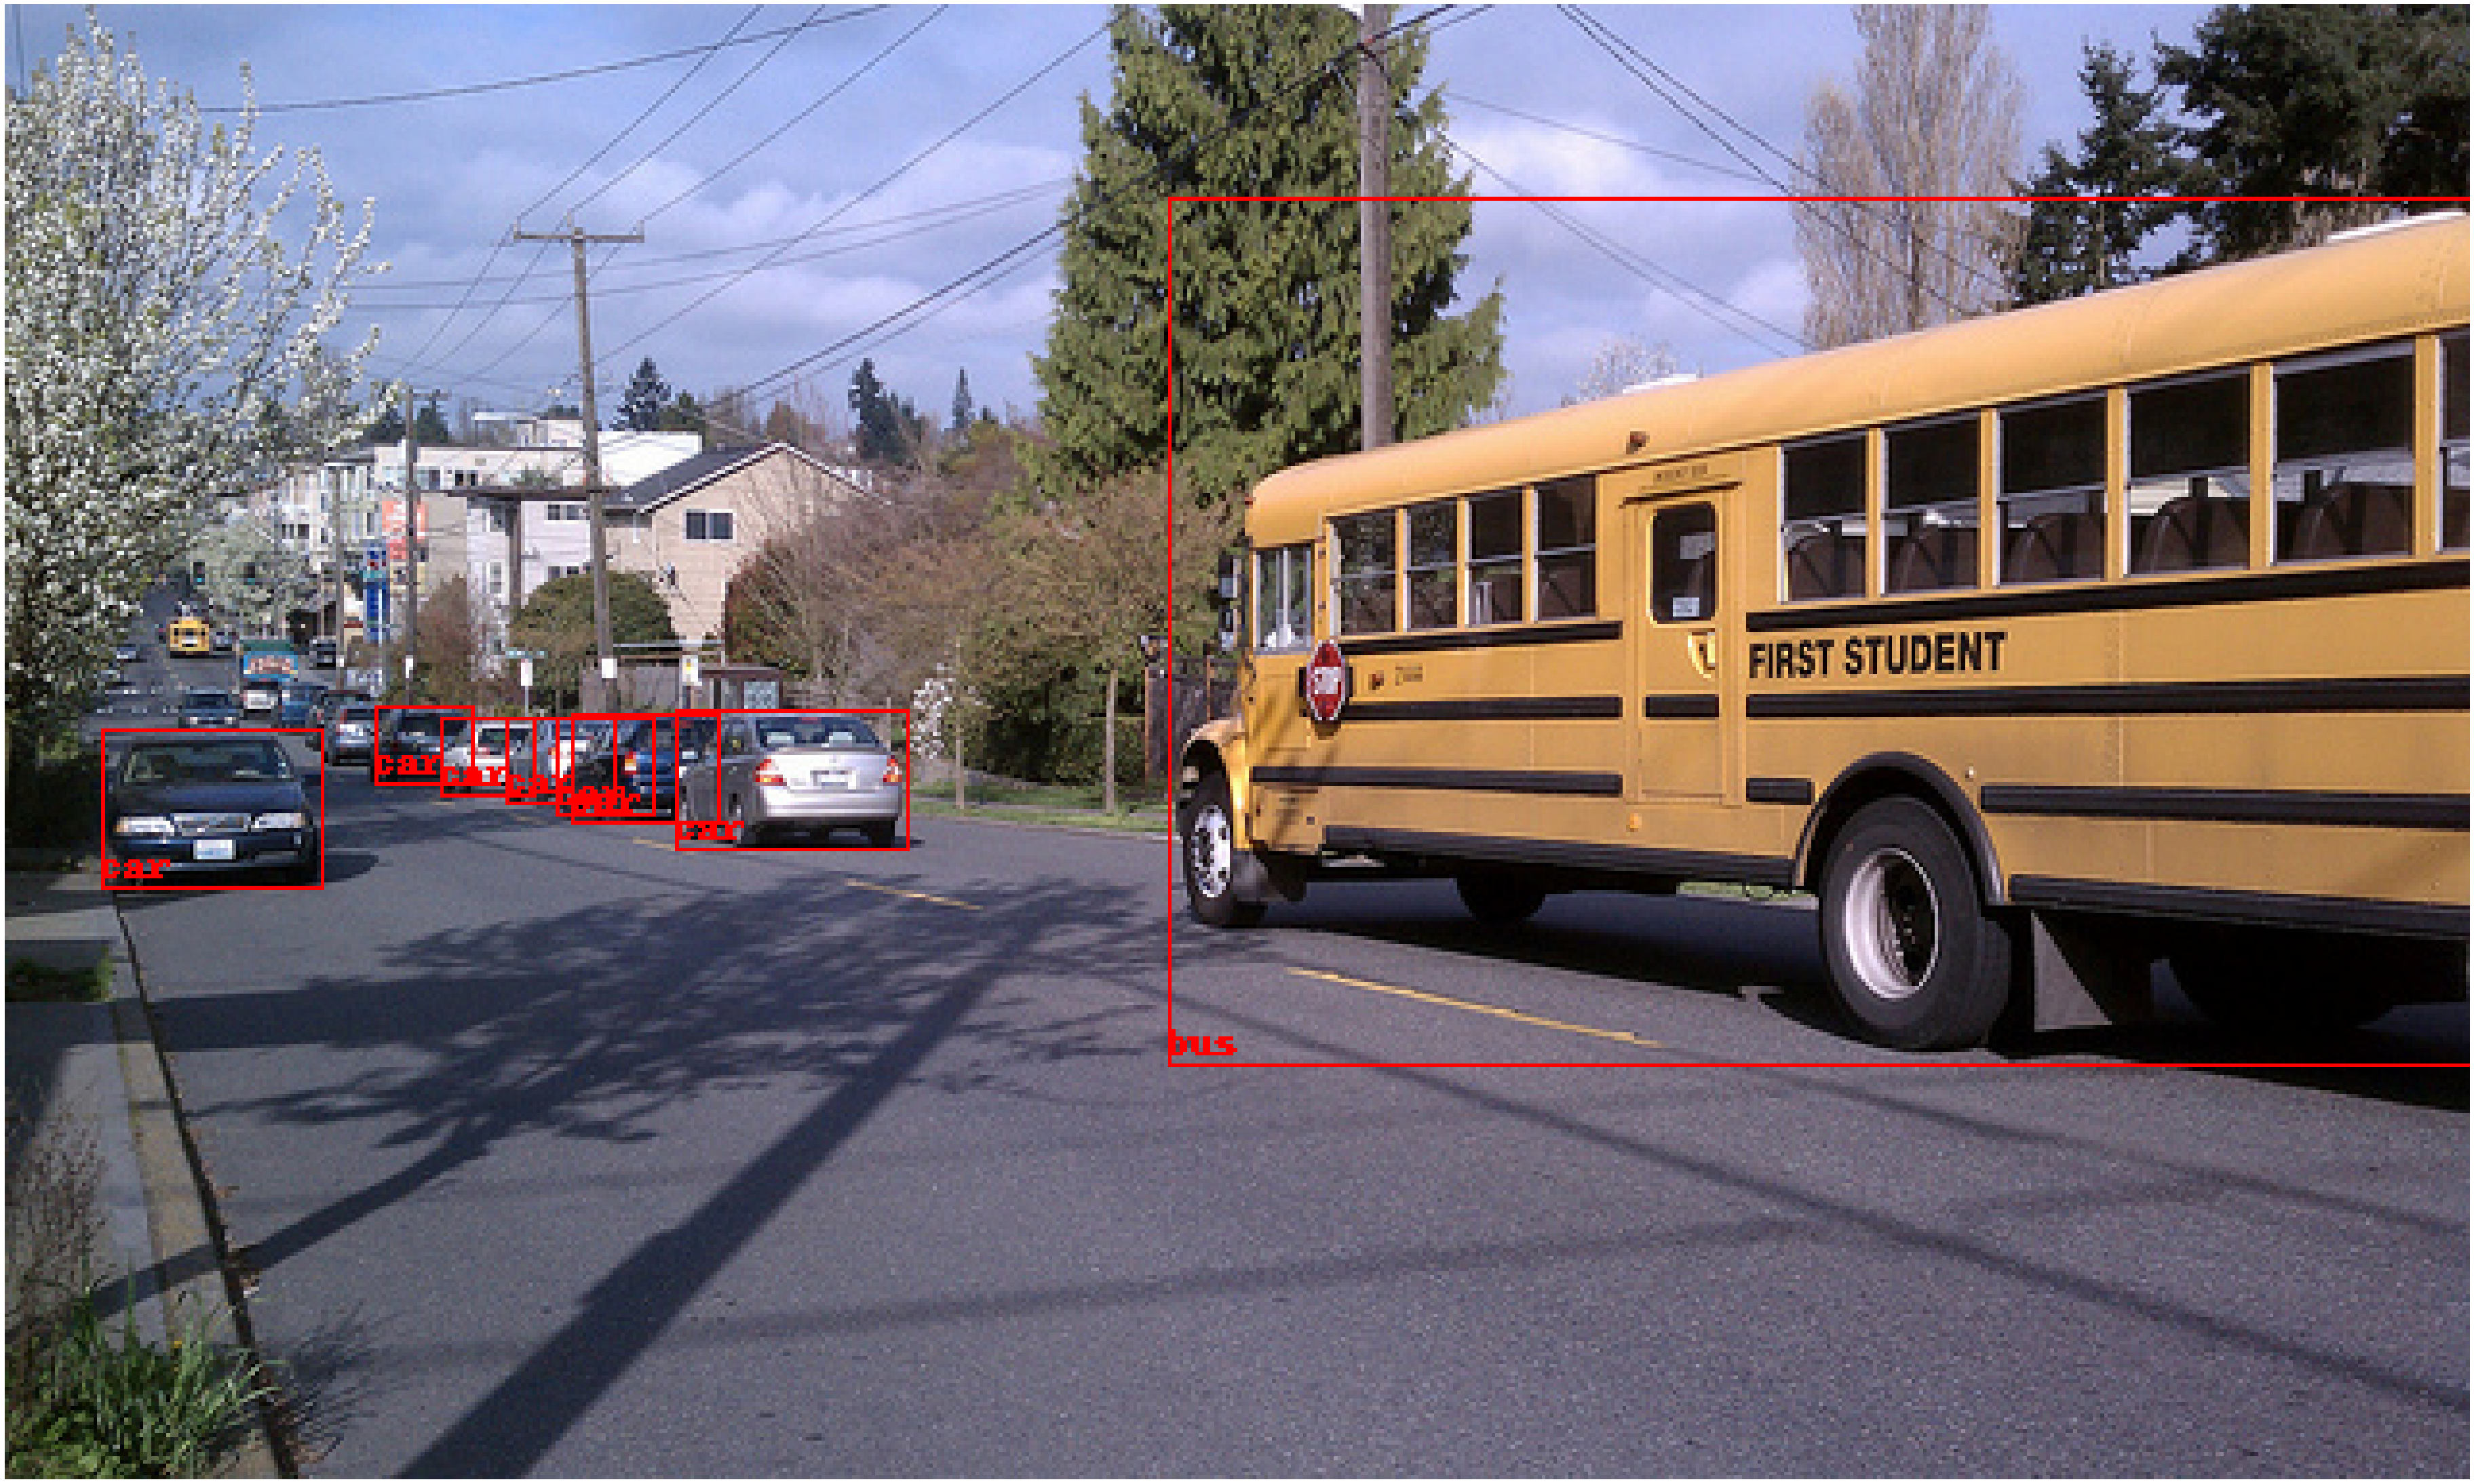

In [32]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    tf.compat.v1.saved_model.load(sess, ['serve'], os.path.join(".", MODEL))
    detections = sess.run('detections:0', {"image_arrays:0": images})
    print("results:", detections.shape)
    for batch in range(0, detections.shape[0]):
        one_image(images[batch], detections[batch])

### Run the inference using onnxruntime

In [33]:
import onnxruntime as rt
sess = rt.InferenceSession(MODEL + ".onnx")

results: (1, 8, 7)


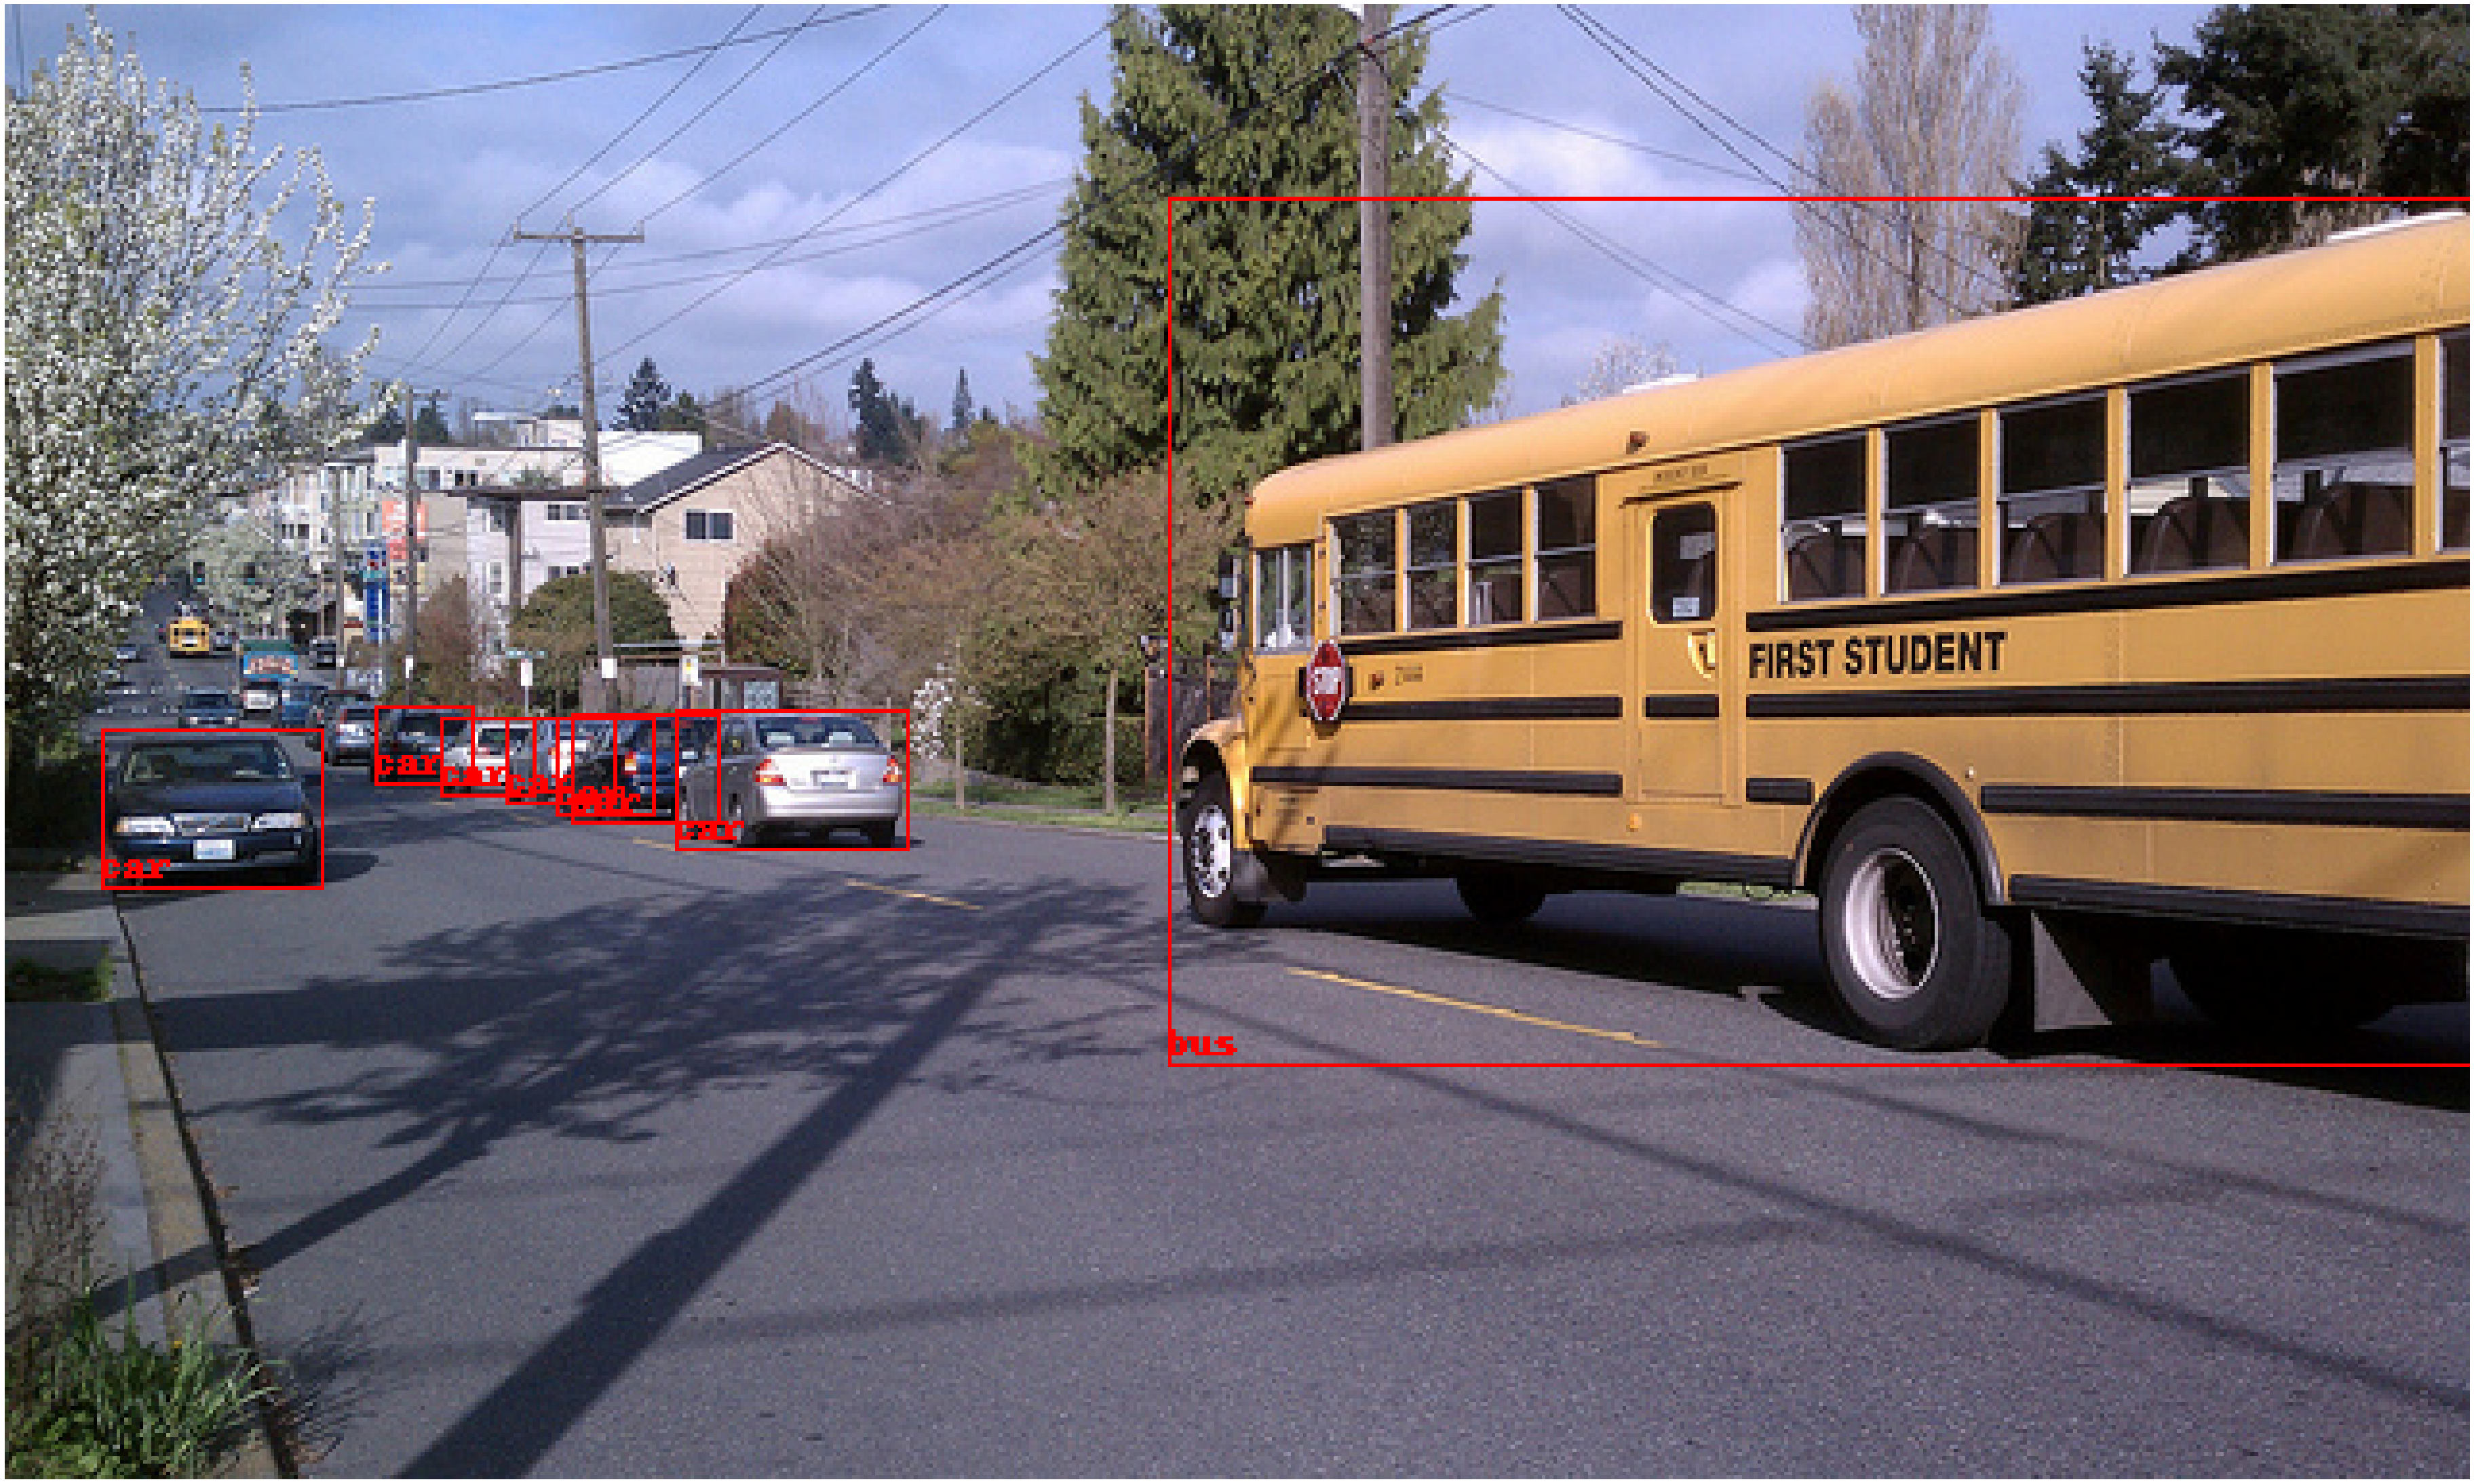

In [34]:
detections = sess.run(['detections:0'], {"image_arrays:0": images})[0]
print("results:", detections.shape)
for batch in range(0, detections.shape[0]):
    one_image(images[batch], detections[batch])